In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

### Import data

In [2]:
df = pd.read_csv('./New_cars_cleaned.csv')
print('Shape', df.shape)

Shape (32316, 56)


### Analyze columns and drop some if needed

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32316 entries, 0 to 32315
Data columns (total 56 columns):
MSRP                                    32262 non-null float64
EPA Fuel Economy Est - City (MPG)       27027 non-null float64
Engine                                  30341 non-null object
Drivetrain                              30600 non-null object
Passenger Capacity                      32316 non-null int64
Passenger Doors                         32316 non-null int64
Base Curb Weight (lbs)                  19456 non-null float64
Passenger Volume (ft³)                  16756 non-null float64
Wheelbase (in)                          30301 non-null float64
Track Width, Front (in)                 20130 non-null float64
Height, Overall (in)                    15628 non-null float64
Fuel Tank Capacity, Approx (gal)        15615 non-null float64
SAE Net Torque @ RPM                    30249 non-null float64
Fuel System                             29486 non-null object
SAE Net Horsepow

In [4]:
# Check some of the features and remove the if they seem too specific/exotic and thus not falling into the average car
df['Night Vision'].value_counts()

0    32272
1       44
Name: Night Vision, dtype: int64

In [5]:
df['Rollover Protection Bars'].value_counts()

0    31130
1     1186
Name: Rollover Protection Bars, dtype: int64

In [6]:
df = df.drop(['Night Vision', 'Rollover Protection Bars'], axis=1)

In [7]:
# Remove Electrical cars from data as technically different factors have influence

print('Number of entries with electric engines: ', df[df['Engine'] == 'Electric'].shape[0])
df = df[df['Engine'] != 'Electric']
df.shape

Number of entries with electric engines:  174


(32142, 54)

In [8]:
df['Front tire width'].value_counts()

235    4247
245    3910
225    3593
265    2687
215    2497
205    2470
255    2211
an     1988
T24    1734
275    1389
195    1234
25/     522
T26     494
185     434
T27     408
175     337
285     269
T23     256
05/     187
35/     179
55/     158
15/     121
45/     116
95/      92
T22      82
T21      66
T28      57
65/      56
85/      53
T25      49
T19      48
75/      45
165      42
295      39
155      33
T31      13
305       7
1x1       6
0 x       6
35-       2
8"        2
HR2       1
325       1
315       1
Name: Front tire width, dtype: int64

In [9]:
# Drop 'Front tire width', because data entries are wrong
df = df.drop('Front tire width', axis=1)
df.shape

(32142, 53)

In [10]:
# Clean rows with missing target value data
df.dropna(subset=['MSRP'], inplace=True)
df.shape

(32092, 53)

In [11]:
# Drop columns with missing threshold of values
global df_temp
global col_means
col_means = []
thresh = 0.1
for col in df.columns:
    col_means.append(df.isna().mean()[col])
df_temp = df
for i in range(len(col_means)):
    if col_means[i] >= thresh:
        df_temp = df_temp.drop(df.columns[i],axis=1)
df_temp = df_temp.dropna()
print('For threshold {} shape is {}'.format(thresh, df_temp.shape))
df = df_temp


For threshold 0.1 shape is (27885, 41)


In [12]:
cat_columns = []
for col in df:
    if df[col].dtypes == 'object':
        cat_columns.append(col)
cat_columns

['Engine',
 'Drivetrain',
 'Fuel System',
 'Trans Description Cont.',
 'Trans Type',
 'Suspension Type - Front',
 'Suspension Type - Rear',
 'Front Wheel Material',
 'Manufacturer',
 'Category']

Lower bound: -1460.000, upper bound: 67340.000
Percentiles: 25th=24340.000, 75th=41540.000, IQR=17200.000
Mean: 38680.74904070289
StDev: 32092.76761844043
median: 31600.0


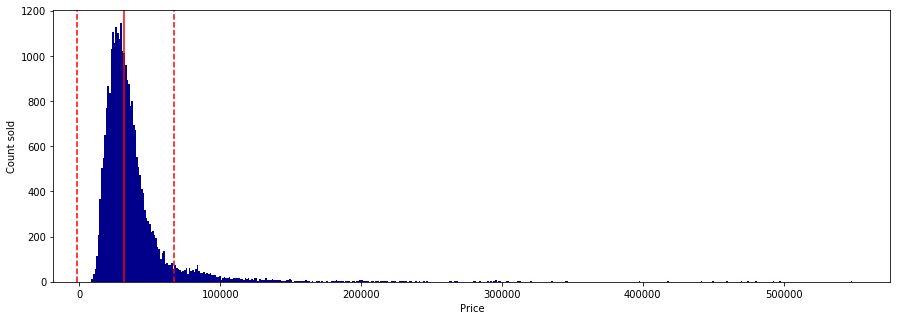

In [13]:
# Use IQR because data distribution is not Gaussian
# Calculate the interquartile range and use it to filter data to be used. 
mean = np.mean(df['MSRP'])
median = np.percentile(df['MSRP'], 50)
stdev= np.std(df['MSRP'])
q25, q75 = np.percentile(df['MSRP'], 25), np.percentile(df['MSRP'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
price_lower_bound, price_upper_bound = q25 - cut_off, q75 + cut_off
print('Lower bound: %.3f, upper bound: %.3f' % (price_lower_bound, price_upper_bound))
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
print('Mean:', mean)
print('StDev:', stdev)
print('median:', median)
fig, ax1 = plt.subplots(1, figsize=(15, 5))
ax1.hist(df['MSRP'], bins='auto', color='darkblue')
plt.xlabel('Price')
plt.ylabel('Count sold')
plt.axvline(x=median, color='r', linestyle='-')
plt.axvline(x=price_lower_bound, color='r', linestyle='--')
plt.axvline(x=price_upper_bound, color='r', linestyle='--')
plt.show()

In [14]:
# Cut entries outside the IQR
df = df[df['MSRP'] <= price_upper_bound]

In [15]:
df.shape

(25730, 41)

In [16]:
# Count how many engine types
df['Engine'].value_counts()

l4      9280
V6      7543
V8      6926
Flat     793
l5       490
I6       376
l6       204
l3       104
W8         8
V10        6
Name: Engine, dtype: int64

In [17]:
# Map same types of engines
df.replace({'I6':'l6'}, inplace=True)

/home/aaa/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [18]:
# Map same types of drivetrains
repl_dict_drtrain = {
    "AWD" : "4WD"
}
df.replace(repl_dict_drtrain, inplace=True)

In [19]:
# Function to calculate the relative standard deviation of price
# for the respective categorical feature
def rel_std_cat_feature(feature):
    ax = df.groupby([feature])['MSRP'].mean().plot.bar()
    ax.set_ylabel('Mean Price')
    ax.set_title('Relative standard deviation: {:.2f}'.format\
        (df.groupby([feature])['MSRP'].mean().std()/df['MSRP'].mean()))
    print('Relative standard deviation:', \
        (df.groupby([feature])['MSRP'].mean().std()/df['MSRP'].mean()))

Relative standard deviation: 0.2472432398059593


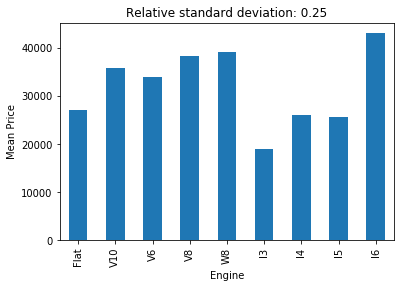

In [20]:
rel_std_cat_feature('Engine')

Relative standard deviation: 0.18158945787354447


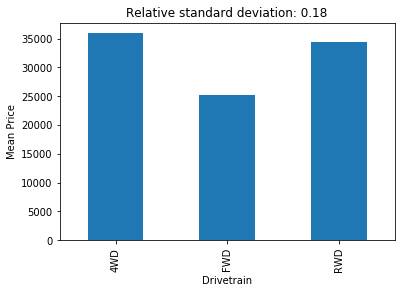

In [21]:
rel_std_cat_feature('Drivetrain')

Relative standard deviation: 0.07822151482306339


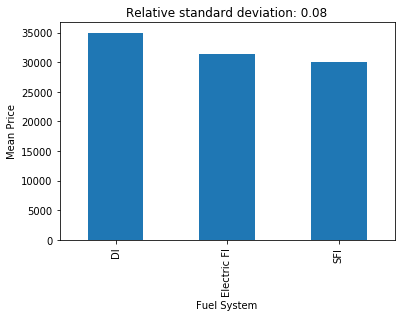

In [22]:
rel_std_cat_feature('Fuel System')

Relative standard deviation: 0.12112799695280688


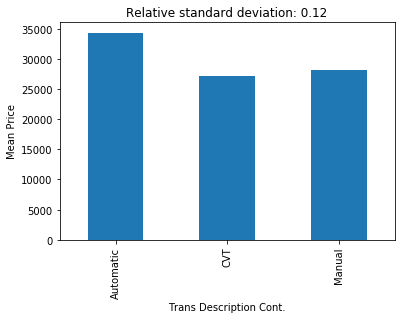

In [23]:
rel_std_cat_feature('Trans Description Cont.')

Relative standard deviation: 0.29064195429883033


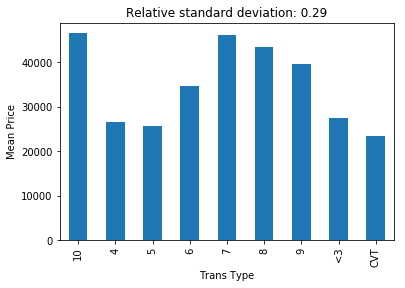

In [24]:
rel_std_cat_feature('Trans Type')

Relative standard deviation: 0.30702057596203064


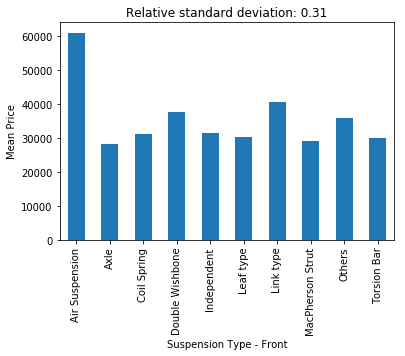

In [25]:
rel_std_cat_feature('Suspension Type - Front')

Relative standard deviation: 0.29395629671447676


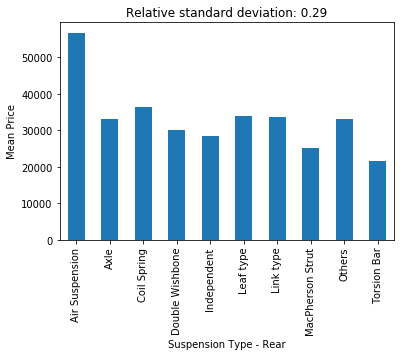

In [26]:
rel_std_cat_feature('Suspension Type - Rear')

Relative standard deviation: 0.39385884441367625


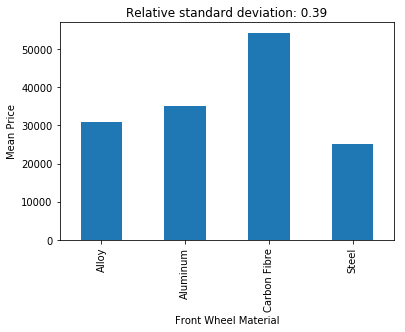

In [27]:
rel_std_cat_feature('Front Wheel Material')

Relative standard deviation: 0.06295062346792163


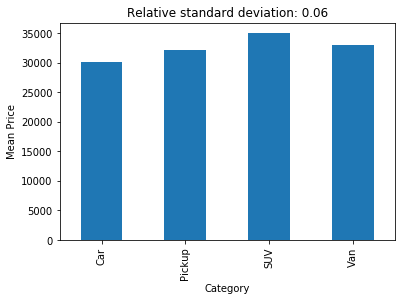

In [28]:
rel_std_cat_feature('Category')

Relative standard deviation: 0.32773831886044746


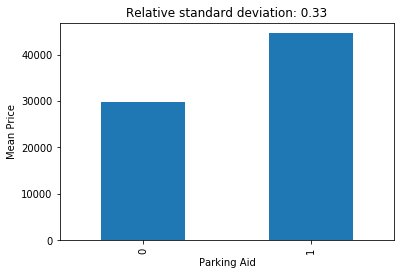

In [29]:
rel_std_cat_feature('Parking Aid')

Relative standard deviation: 0.20493726401647


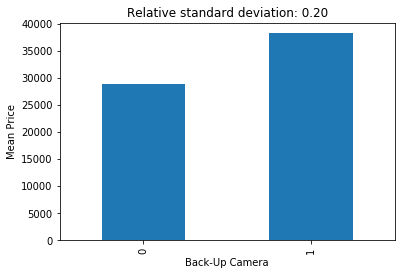

In [30]:
rel_std_cat_feature('Back-Up Camera')

Relative standard deviation: 0.33912686327352565


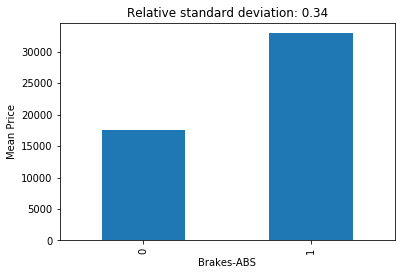

In [31]:
rel_std_cat_feature('Brakes-ABS')

Relative standard deviation: 0.22316812454841023


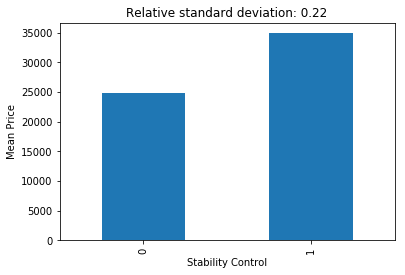

In [32]:
rel_std_cat_feature('Stability Control')

Relative standard deviation: 0.22704756027180673


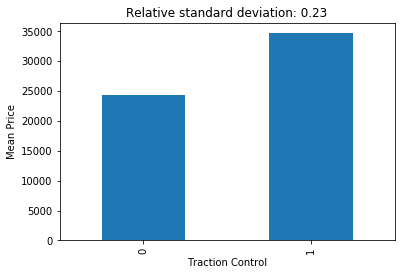

In [33]:
rel_std_cat_feature('Traction Control')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text xticklabel objects>)

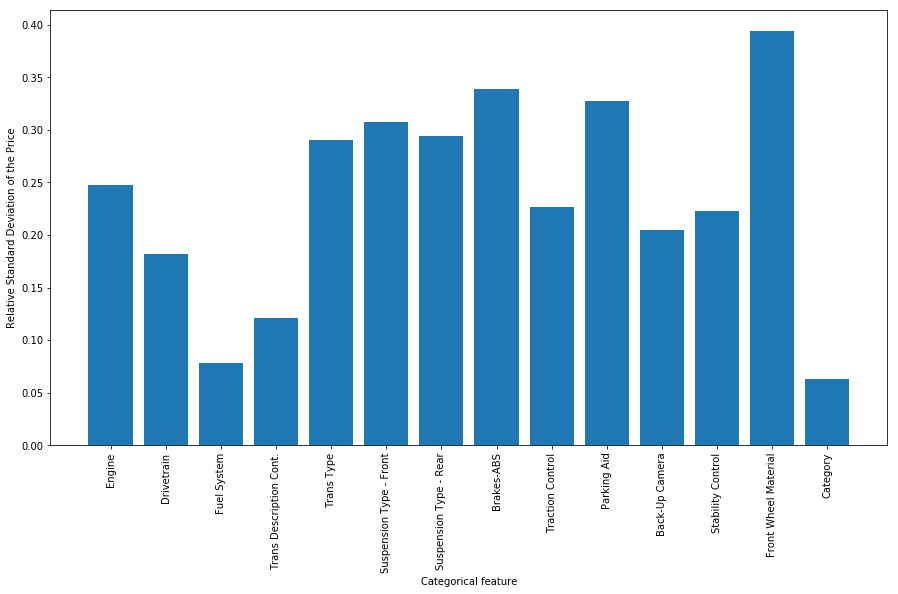

In [34]:
# Plot all relative standard deviations on one graph
feature = []
rsd = []
for col in df.columns:
    if (df[col].dtypes == 'object' or col in ['Parking Aid', 'Back-Up Camera', 'Brakes-ABS', 'Stability Control', 'Traction Control']) and col != 'Manufacturer':
        feature.append(col)
        rsd.append(df.groupby([col])['MSRP'].mean().std()/df['MSRP'].mean())

fig, ax = plt.subplots(1, figsize=(15, 8))
plt.xlabel('Categorical feature')
plt.ylabel('Relative Standard Deviation of the Price')
ax.bar(feature,rsd)
plt.xticks(rotation=90)

### Analyze Manufacturer influence

Relative standard deviation: 0.3971089526465112
Mean price: 32061.258919549164


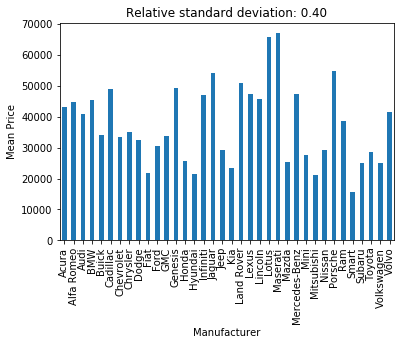

In [35]:
# Plot the relative standard deviation for Manufacturer as category
rel_std_cat_feature('Manufacturer')
print('Mean price:', df['MSRP'].mean())

In [36]:
# As can be seen the imbalance is mainly dur to Maseratti, Lotus, Porsche, Jaguar, Land Rover and Genesis
# We should see how many entries those manufacturer have in the sample

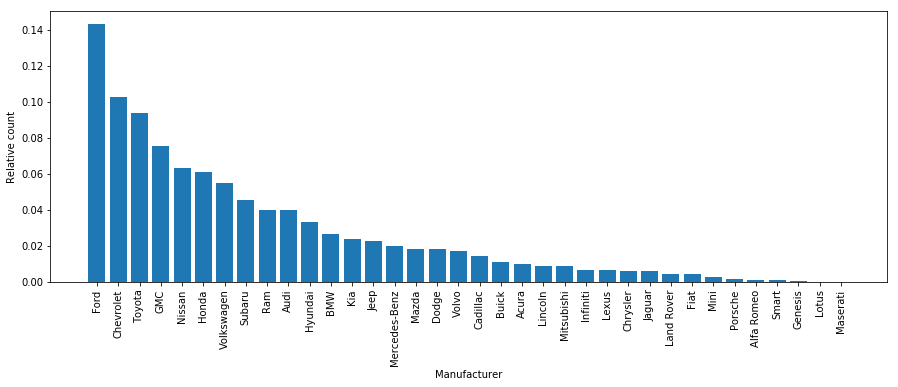

In [37]:
fig, ax1 = plt.subplots(1, figsize=(15, 5))
ax1.bar(df['Manufacturer'].value_counts().index,df['Manufacturer'].value_counts()/df.shape[0])
plt.xticks(rotation=90)
plt.xlabel('Manufacturer')
plt.ylabel('Relative count')
plt.show()

In [38]:
# Maseratti, Lotus, Porsche, Jaguar, Land Rover and Genesis have all less than 1% proportion of all sold cars

In [39]:
# Plot relative standard deviation without those manufacturers
man_exclude = [
    'Maseratti',
    'Lotus',
    'Porsche',
    'Jaguar',
    'Land Rover',
    'Genesis'
]


In [40]:
# List of manufacturers over a thresh of relative count
thresh = 0.02
manuf_counts = df['Manufacturer'].value_counts()/df.shape[0]
manuf_name = manuf_counts[manuf_counts >= thresh].index
manuf_name = list(manuf_name)

In [41]:
# Exclude manufacturer under the threshold
df_man_count = df[df['Manufacturer'].isin(manuf_name)]
df_man_count.shape

(21301, 41)

Relative standard deviation: 0.22871910241320811


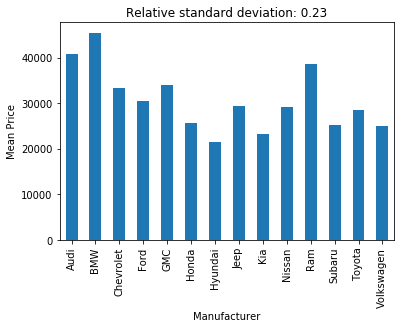

In [42]:
feature = 'Manufacturer'
ax = df_man_count.groupby([feature])['MSRP'].mean().plot.bar()
ax.set_ylabel('Mean Price')
ax.set_title('Relative standard deviation: {:.2f}'.format\
        (df_man_count.groupby([feature])['MSRP'].mean().std()/df_man_count['MSRP'].mean()))
print('Relative standard deviation:', \
    (df_man_count.groupby([feature])['MSRP'].mean().std()/df_man_count['MSRP'].mean()))

### Encode some categorical features

In [43]:
def create_dummy_df(df, cat_cols, dummy_na=False):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    '''
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1),pd.get_dummies(df[col], prefix=col, \
                dummy_na=dummy_na, drop_first=True)],axis=1)
        except:
            continue
    return df

In [44]:
category_columns_encode = ['Front Wheel Material', 'Suspension Type - Front', 'Parking Aid', 'Back-Up Camera', 'Brakes-ABS', 'Stability Control', 'Traction Control',  'Manufacturer']

In [45]:
df = create_dummy_df(df, category_columns_encode)
#df.info()

### Feature selection with Pearson correlation

In [46]:
df.corr()['MSRP'].sort_values()

Front Wheel Material_Steel                 -0.369607
Front tire aspect ratio                    -0.284498
Suspension Type - Front_MacPherson Strut   -0.224824
Manufacturer_Hyundai                       -0.175560
Manufacturer_Volkswagen                    -0.153609
Drivetrain Years                           -0.146818
Manufacturer_Honda                         -0.145173
Manufacturer_Subaru                        -0.135365
Manufacturer_Kia                           -0.121891
Air Bag-Passenger Switch (On/Off)          -0.113858
Manufacturer_Toyota                        -0.102319
Manufacturer_Mitsubishi                    -0.093945
Manufacturer_Mazda                         -0.083463
Manufacturer_Nissan                        -0.067649
Manufacturer_Fiat                          -0.060611
Corrosion Miles/km                         -0.060246
Manufacturer_Ford                          -0.054579
Manufacturer_Smart                         -0.048808
Suspension Type - Front_Torsion Bar        -0.

In [47]:
# Pearson correletaion
pears_thresh = 0.3 # Medium degree of correlation
feature_list_name = []
for ind, val in df.corr()['MSRP'].sort_values().items():
    if abs(val) >= pears_thresh and val < 1: # Exclude MSRP
        print('Appending', ind)
        feature_list_name.append(ind)

Appending Front Wheel Material_Steel
Appending Tire Pressure Monitor
Appending Brakes-ABS_1
Appending Front Wheel Material_Aluminum
Appending Back-Up Camera_1
Appending Model year
Appending Traction Control_1
Appending Stability Control_1
Appending Displacement
Appending Parking Aid_1
Appending SAE Net Torque @ RPM
Appending SAE Net Horsepower @ RPM


### Machine learning modeling

In [48]:
X = df[feature_list_name]
y = df['MSRP']

In [49]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42) 

In [50]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(normalize=True)

In [51]:
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.7338888612492978 on 5146 values.'

In [56]:
# Enter the parameters of a psecific car
# Example middle class family car 
car = {
    'Front Wheel Material_Steel': [0],
    'Tire Pressure Monitor': [1],
    'Brakes-ABS_1': [1],
    'Front Wheel Material_Aluminum': [1],
    'Back-Up Camera_1': [0],
    'Model year': [2020],
    'Traction Control_1': [1],
    'Stability Control_1': [1],
    'Displacement': [1.4],
    'Parking Aid_1': [1],
    'SAE Net Torque @ RPM': [250],
    'SAE Net Horsepower @ RPM': [140]
}

df_car = pd.DataFrame.from_dict(car, orient='columns')
df_car.head()

,Front Wheel Material_Steel,Tire Pressure Monitor,Brakes-ABS_1,Front Wheel Material_Aluminum,Back-Up Camera_1,Model year,Traction Control_1,Stability Control_1,Displacement,Parking Aid_1,SAE Net Torque @ RPM,SAE Net Horsepower @ RPM
0,0,1,1,1,0,2020,1,1,1.4,1,250,140


In [57]:
# Predict car price using the model
lm_model.predict(df_car)

array([35715.02407078])